In [15]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_lattice as tfl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(1)

In [16]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

n_train = 16

# trainning set
Tz_k   = np.array(df['room_temp']).reshape(-1,1)[0: n_train]
Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[1: n_train+1]
msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[1: n_train+1]
z      = ((msa_k1-400)/600)*(Tsa_k1-Tz_k)
Tz_k1  = np.array(df['room_temp']).reshape(-1,1)[1: n_train+1]

X = np.concatenate((Tz_k, z), axis=1)
Y = np.copy(Tz_k1)

# test set
Tz_k_t   = np.array(df['room_temp']).reshape(-1,1)[n_train: 1600]
Tsa_k1_t = np.array(df['supply_discharge_temp']).reshape(-1,1)[n_train+1: 1600+1]
msa_k1_t = np.array(df['airflow_current']).reshape(-1,1)[n_train+1: 1600+1]
z_t      = ((msa_k1_t-400)/600)*(Tsa_k1_t-Tz_k_t)
Tz_k1_t  = np.array(df['room_temp']).reshape(-1,1)[n_train+1: 1600+1]

X_t = np.concatenate((Tz_k_t, z_t), axis=1)
Y_t = np.copy(Tz_k1_t)

In [17]:
# combined calibrator
combined_calibrators = tfl.layers.ParallelCombination()

calibrator_x1 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(65,85,10), output_min=0, output_max=2)
calibrator_x2 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(-1,20,10), output_min=0, output_max=2, monotonicity='increasing')

combined_calibrators.append(calibrator_x1)
combined_calibrators.append(calibrator_x2)

# Lattice
lattice = tfl.layers.Lattice(
    lattice_sizes = [3, 3],
    monotonicities = ['increasing', 'increasing'],
    output_min = 65,
    output_max = 85)

In [18]:
model = tf.keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)

In [19]:
model.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = [tfa.metrics.RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

hist = model.fit(
    x = X,
    y = Y,
    batch_size = 256,
    epochs = 20000,
    shuffle = False,
    validation_data=(X_t, Y_t),
    callbacks=[callback],
    verbose = 1)

Epoch 1/20000
1/1 [==============================] - 1s 570ms/step - loss: 4.6901 - r_square: -63.9005 - val_loss: 4.1270 - val_r_square: -0.2200
Epoch 2/20000
1/1 [==============================] - 0s 16ms/step - loss: 3.7846 - r_square: -51.3704 - val_loss: 4.0169 - val_r_square: -0.1874
Epoch 3/20000
1/1 [==============================] - 0s 17ms/step - loss: 2.9802 - r_square: -40.2398 - val_loss: 4.0249 - val_r_square: -0.1898
Epoch 4/20000
1/1 [==============================] - 0s 17ms/step - loss: 2.2781 - r_square: -30.5244 - val_loss: 4.1472 - val_r_square: -0.2259
Epoch 5/20000
1/1 [==============================] - 0s 16ms/step - loss: 1.6785 - r_square: -22.2263 - val_loss: 4.3777 - val_r_square: -0.2941
Epoch 6/20000
1/1 [==============================] - 0s 15ms/step - loss: 1.1801 - r_square: -15.3302 - val_loss: 4.7076 - val_r_square: -0.3916
Epoch 7/20000
1/1 [==============================] - 0s 15ms/step - loss: 0.7805 - r_square: -9.8004 - val_loss: 5.1253 - val_r_s

1


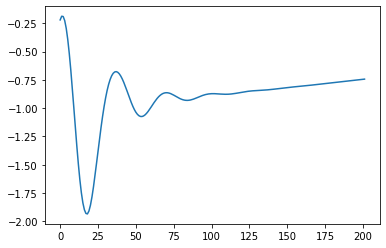

In [20]:
print(np.argmax(hist.history['val_r_square']))
# plot metrics
plt.plot(hist.history['val_r_square'])
plt.show()

50/50 [==============================] - 0s 469us/step - loss: 5.8976 - r_square: -0.7448
R2 test data: -0.7448387145996094


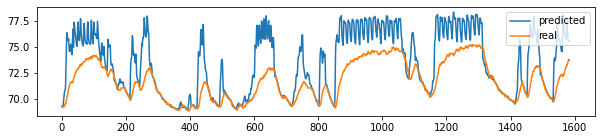

In [21]:
print("R2 test data:", model.evaluate(X_t, Y_t)[1])

plt.figure(figsize=(10,2))
plt.plot(model(X_t), label='predicted')
plt.plot(Y_t, label='real')
plt.legend()
plt.show()